In [15]:
#importing utilities
import os
import time
import pandas as pd
import seaborn as sns
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
import torch
from torch.utils.data import Dataset, DataLoader, random_split, RandomSampler, SequentialSampler
torch.manual_seed(42)
from transformers import GPT2LMHeadModel,  GPT2Tokenizer, GPT2Config, GPT2LMHeadModel
from transformers import AdamW, get_linear_schedule_with_warmup
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [4]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.1 MB/s eta 0:00:00


In [3]:
# defining a dataset class to create a GPT2 like dataset for e.g adding necessary input_ids and attention masks
class CreateGPT2Dataset(Dataset):

  def __init__(self, txt_list, tokenizer, gpt2_type="gpt2", max_length=768):

    self.tokenizer = tokenizer          # setting the tokenizer
    self.input_ids = []                 # creating inputmasks
    self.attn_masks = []                # attention masks
    for txt in txt_list:
      encodings_dict = tokenizer('<|startoftext|>'+ txt + '<|endoftext|>', truncation=True, max_length=max_length, padding="max_length")
      self.input_ids.append(torch.tensor(encodings_dict['input_ids']))
      self.attn_masks.append(torch.tensor(encodings_dict['attention_mask']))

  def __len__(self):
    return len(self.input_ids)

  def __getitem__(self, idx):
    return self.input_ids[idx], self.attn_masks[idx]

In [5]:
# importing the tokenizer for using on the dataset
tokenizer = GPT2Tokenizer.from_pretrained('gpt2', bos_token='<|startoftext|>', eos_token='<|endoftext|>', pad_token='<|pad|>') #gpt2-medium

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

In [7]:
# loading and creating the dataset for training and evaluation, I have already preprocessed the dataset and uploaded it to huggingface
from datasets import load_dataset
dataset = load_dataset('retr0sushi04/html_pre_processed', split='train')
dataset = CreateGPT2Dataset(dataset['text'], tokenizer)

# Split into training and validation sets
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{} training samples'.format(train_size))
print('{} validation samples'.format(val_size))

26 training samples
3 validation samples


In [8]:
# setting batch size
batch_size = 2

In [9]:
# creating pytorch dataloaders for the training and validation datasets
train_dataloader = DataLoader(train_dataset, sampler = RandomSampler(train_dataset), batch_size=batch_size)
validation_dataloader = DataLoader(val_dataset, sampler = SequentialSampler(val_dataset), batch_size=batch_size)

In [10]:
# loading the GPT2 model for fine-tuning
config = GPT2Config.from_pretrained('gpt2')
model = GPT2LMHeadModel.from_pretrained('gpt2', config=config)
model.resize_token_embeddings(len(tokenizer))
device = torch.device("cuda")
model.cuda() #putting the model on GPU

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50259, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50259, bias=False)
)

In [14]:
# setting up the parameters for the model
epochs = 20 ; learning_rate = 2e-4 ; warmup_steps = 1e2 ; epsilon = 1e-8
# setting up the optimizer
optimizer = AdamW(model.parameters(), lr=learning_rate, eps=epsilon)
# defining number of steps
total_steps = len(train_dataloader) * epochs
# setting up the scheduler
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=warmup_steps, num_training_steps=total_steps)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [17]:
import datetime
def format_time(elapsed):
    return str(datetime.timedelta(seconds=int(round((elapsed)))))

In [20]:
import time

In [21]:
# training loop
model = model.to(device)
total_time = time.time()
training_stats = []
for epoch_i in range(0, epochs):
  print("\nTraining ....")
  print('Epoch {:} / {:}'.format(epoch_i + 1, epochs))
  t0 = time.time()
  total_train_loss = 0
  model.train()
  for step, batch in enumerate(train_dataloader):
    batch_input_ids = batch[0].to(device)
    batch_labels = batch[0].to(device)
    batch_masks = batch[1].to(device)
    model.zero_grad()
    outputs = model(input_ids=batch_input_ids, attention_mask=batch_masks, labels=batch_labels, token_type_ids=None)
    loss = outputs[0]
    batch_loss = loss.item()
    total_train_loss += batch_loss
    if step % 100 == 0 and not step == 0:
      elapsed_time = format_time(time.time() - time)
      print(' Batch {:} of {:}. Loss : {:}.  Elapsed : {:}'.format(step, len(train_dataloader)), batch_loss, elapsed)
      model.eval()
      sample_outputs = model.generate(
          bos_token_id=random.randint(1,30000),
          do_sample=True,
          top_k=50,
          max_length=200,
          top_p=0.95,
          num_return_sequences=1
      )
      for i, sample_output in enumerate(sample_outputs):
          print("{}: {}".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))
      model.train()
    loss.backward()
    optimizer.step()
    scheduler.step()
  avg_train_loss = total_train_loss / len(train_dataloader)
  training_time = format_time(time.time() - t0)
  print("Time taken by epoch : {:}".format(training_time))
  print("Average training loss : {:}".format(avg_train_loss))
  # validation
  print("")
  print("Running validation ....")
  t0 = time.time()
  model.eval()
  total_eval_loss = 0
  no_eval_steps = 0
  for batch in validation_dataloader:
    batch_input_ids = batch[0].to(device)
    batch_labels = batch[0].to(device)
    batch_masks = batch[1].to(device)
    with torch.no_grad():
      outputs = model(input_ids=batch_input_ids, attention_mask=batch_masks, labels=batch_labels, token_type_ids=None)
      loss = outputs[0]
    total_eval_loss += loss.item()
    no_eval_steps += 1
  avg_eval_loss = total_eval_loss / no_eval_steps
  validation_time = format_time(time.time() - t0)
  print("Validation loss : {:}".format(avg_eval_loss))
  print("Validation took : {:}".format(validation_time))
  training_stats.append(
      {
          'epoch': epoch_i + 1,
          'Training Loss': avg_train_loss,
          'Valid. Loss': avg_eval_loss,
          'Training Time': training_time,
          'Validation Time': validation_time
      }
  )

print("")
print("Training complete !")
print("Total training took {:} (h:mm:ss)".format(format_time(time.time() - total_time)))


Training ....
Epoch 1 / 20
Time taken by epoch : 0:00:07
Average training loss : 6.670944874103252

Running validation ....
Validation loss : 4.111083626747131
Validation took : 0:00:00

Training ....
Epoch 2 / 20
Time taken by epoch : 0:00:07
Average training loss : 3.7368511328330407

Running validation ....
Validation loss : 3.017159163951874
Validation took : 0:00:00

Training ....
Epoch 3 / 20
Time taken by epoch : 0:00:07
Average training loss : 2.8809371361365685

Running validation ....
Validation loss : 2.3863840103149414
Validation took : 0:00:00

Training ....
Epoch 4 / 20
Time taken by epoch : 0:00:07
Average training loss : 2.4551214438218336

Running validation ....
Validation loss : 2.4376646876335144
Validation took : 0:00:00

Training ....
Epoch 5 / 20
Time taken by epoch : 0:00:07
Average training loss : 2.2472281731092014

Running validation ....
Validation loss : 2.217306911945343
Validation took : 0:00:00

Training ....
Epoch 6 / 20
Time taken by epoch : 0:00:07
A

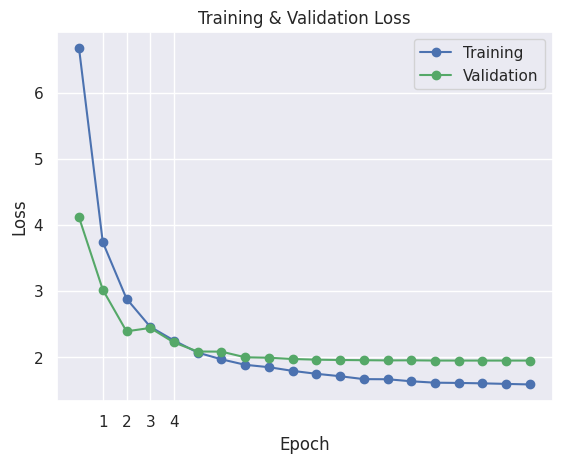

In [23]:
# plotting the run
stats = pd.DataFrame(data = training_stats)
stats.set_index('epoch')
# Use plot styling from seaborn.
sns.set(style='darkgrid')
# Increase the plot size and font size.
# Plot the learning curve.
plt.plot(stats['Training Loss'], 'b-o', label="Training")
plt.plot(stats['Valid. Loss'], 'g-o', label="Validation")
# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])
plt.show()

In [24]:
output_dir = './model_save/'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
print("Saving model to %s" % output_dir)
model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

Saving model to ./model_save/


('./model_save/tokenizer_config.json',
 './model_save/special_tokens_map.json',
 './model_save/vocab.json',
 './model_save/merges.txt',
 './model_save/added_tokens.json')

In [25]:
# infer model
model.eval()
prompt = "<s> [INST]Create a landing page [/INST]"
generated = torch.tensor(tokenizer.encode(prompt)).unsqueeze(0)
generated = generated.to(device)
print(generated)
sample_outputs = model.generate(
                                generated,
                                #bos_token_id=random.randint(1,30000),
                                do_sample=True,
                                top_k=50,
                                max_length = 300,
                                top_p=0.95,
                                num_return_sequences=3
                                )

for i, sample_output in enumerate(sample_outputs):
  print("{}: {}\n\n".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


tensor([[   27,    82,    29,   685, 38604,    60, 16447,   257,  9581,  2443,
         46581, 38604,    60]], device='cuda:0')
0: <s> [INST]Create a landing page [/INST]
[/INST] <div id="nav"></div> <div id="nav">

[/INST] <h1 class="nav nav-bg-1" style="display:none;"></h1> <div id="nav-bg-2" style="display:none;"></div> <div id="container" style="padding-bottom: 1px 0px 2px 0px; transition:all.25rem stroke-rule-name:flex"></div> <div id="container-bg-1" style="display:inline; width:100%!important; height:1px!important;"><a href="https://www.favicon.com/images/gfx-nav_0210.png">https://www.fafp.org/images/gfx-nav-0210.png</a> <a class="container-bg-2" name="container">[INST]Create a landing page [/INST] <div id="nav-bg-2" class="container"><s>
Create a landing page[/INST]

[/s>

 [/INST] <div id="nav-bg-3"></div></div> <div id="nav-bg-4" class="container"><div id="container"></div><div id="nav-bg-4"></div></div> <div id


1: <s> [INST]Create a landing page [/INST] [INST]Create a land